# GERMAN CREDIT MODELING

## Neural Net / Deep Learning Using Keras

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('germancredit.csv',header=0)

## Data Transformations

In [3]:
df['bad'] = df.pop('GoodCredit') - 1

# New Feature: Age Group (Nominal)
df['age_group'] =  pd.cut(df.age13,[18,25,30,50,60,90])

In [4]:
v_nominal = list(df.select_dtypes(include='O').columns)
nominal = v_nominal + ['age_group'] + ['installment8','residence11','liable18']

df = pd.get_dummies(df, columns=nominal, drop_first=True)
df.shape

(1000, 57)

In [5]:
predictors = df.drop('bad',axis=1).columns
print(*sorted(predictors),sep='\t')

age13	age_group_(25, 30]	age_group_(30, 50]	age_group_(50, 60]	age_group_(60, 90]	amount5	cards16	checkingstatus1_A12	checkingstatus1_A13	checkingstatus1_A14	duration2	employ7_A72	employ7_A73	employ7_A74	employ7_A75	foreign20_A202	history3_A31	history3_A32	history3_A33	history3_A34	housing15_A152	housing15_A153	installment8_2	installment8_3	installment8_4	job17_A172	job17_A173	job17_A174	liable18_2	otherplans14_A142	otherplans14_A143	others10_A102	others10_A103	property12_A122	property12_A123	property12_A124	purpose4_A41	purpose4_A410	purpose4_A42	purpose4_A43	purpose4_A44	purpose4_A45	purpose4_A46	purpose4_A48	purpose4_A49	residence11_2	residence11_3	residence11_4	savings6_A62	savings6_A63	savings6_A64	savings6_A65	status9_A92	status9_A93	status9_A94	tele19_A192


In [6]:
from sklearn.preprocessing import StandardScaler

np.random.seed(2018)
rng = np.random.sample(len(df))

X_train = df.loc[rng < 0.6, predictors]
y_train = df.loc[rng < 0.6, 'bad']
X_test  = df.loc[rng >= 0.6, predictors]
y_test  = df.loc[rng >= 0.6, 'bad']

scaler = StandardScaler()
scaler.fit(X_train.values.astype('float'))

X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

## Neural Network - Deep Learning Model

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.constraints import maxnorm

Using TensorFlow backend.


In [33]:
model = Sequential()
model.add(Dense(150, input_dim=len(predictors), activation='relu',
                kernel_initializer='normal',
                kernel_regularizer=regularizers.l1(0.005),
                activity_regularizer=regularizers.l2(0.001),
                name='dense_0'
               ))
model.add(Dropout(0.75, name='dropout_0'))
model.add(Dense(70, input_dim=len(predictors), activation='relu',
                kernel_initializer='normal',
                kernel_regularizer=regularizers.l2(0.01),
                name='dense_a'
               ))
model.add(Dense(1, kernel_initializer='normal',
                activation='sigmoid',name='dence_c'))
model.compile(optimizer='adam',loss='binary_crossentropy',
             metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_0 (Dense)              (None, 150)               8550      
_________________________________________________________________
dropout_0 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_a (Dense)              (None, 70)                10570     
_________________________________________________________________
dence_c (Dense)              (None, 1)                 71        
Total params: 19,191
Trainable params: 19,191
Non-trainable params: 0
_________________________________________________________________


In [43]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20) 
checkpoint = ModelCheckpoint("weights_best.hdf5", monitor='val_loss', 
                             verbose=False, save_best_only=True, mode='min')
history = model.fit(X_train, y_train, epochs=1000, batch_size=12, 
                    verbose=False,
                    validation_data=(X_test,y_test), 
                    callbacks=[early_stopping,checkpoint])

[0.58295294484078597, 0.76086956636917191]

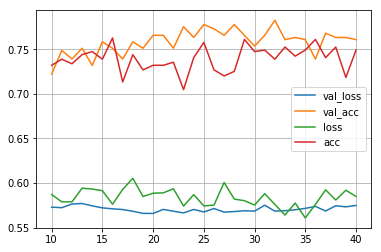

In [44]:
_ = pd.DataFrame(history.history).iloc[10:].plot(grid=True)
model.evaluate(X_test,y_test,verbose=False)

In [45]:
# load weights
model.load_weights("weights_best.hdf5")
# Compile model (required to make predictions)
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

In [46]:
model.evaluate(X_test,y_test)

414/414 [==============================] - 0s 395us/step


[0.57521776041546879, 0.76570048424356807]

In [47]:
from sklearn.metrics import roc_auc_score

y_pred_mlp = model.predict(X_test).ravel()
y_est_mlp  = model.predict(X_train).ravel()

print('MLP Training AUC = {:.2%}       Validation AUC = {:.2%}'.format(
    roc_auc_score(y_train, y_est_mlp),
    roc_auc_score(y_test,  y_pred_mlp)))

MLP Training AUC = 85.17%       Validation AUC = 79.73%


In [48]:
def prob2logit(p):
    return np.log((1-p)/p)

def perturb(model,X,pred):
    
    p_hat = model.predict(X).ravel()

    df = pd.DataFrame()
    
    # amount5
    
    amt_col = np.where([p=='amount5' for p in list(pred)])
    X0 = X.copy()
    X0[:,amt_col] = 0
    X1 = X0.copy()
    X1[:,amt_col] = 1
    
    p_hat_0 = model.predict(X0).ravel()
    p_hat_1 = model.predict(X1).ravel()
    
    df['amount5'] = np.apply_along_axis(prob2logit,0, p_hat_1) - np.apply_along_axis(prob2logit,0, p_hat_0)
    df['amount5_p0'] = p_hat_0
    
    # checkingstatus1_A14
    
    cs4_col = np.where([p=='checkingstatus1_A14' for p in list(pred)])

    cs_cols = [p in ['checkingstatus1_A12','checkingstatus1_A13','checkingstatus1_A14']
                       for p in list(pred)]
    
    X0 = X.copy()
    X0[:,cs_cols] = 0
    X0[:,cs4_col] = 1
    X1 = X0.copy()
    X1[:,cs4_col] = 0
    
    p_hat_0 = model.predict(X0).ravel()
    p_hat_1 = model.predict(X1).ravel()
    
    df['checkingstatus1_A14'] = np.apply_along_axis(prob2logit,0, p_hat_1) - np.apply_along_axis(prob2logit,0, p_hat_0)
    df['checkingstatus1_A14_p0'] = p_hat_0
        
    df.index = p_hat
    print('Perturbation Analysis for model\n\n',model)
    return df

In [49]:
Z = perturb(model,X_train,predictors)
Z[['amount5','checkingstatus1_A14']].mean()

Perturbation Analysis for model



amount5               -0.239707
checkingstatus1_A14   -0.691563
dtype: float32

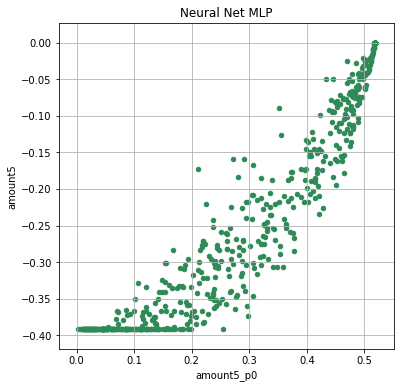

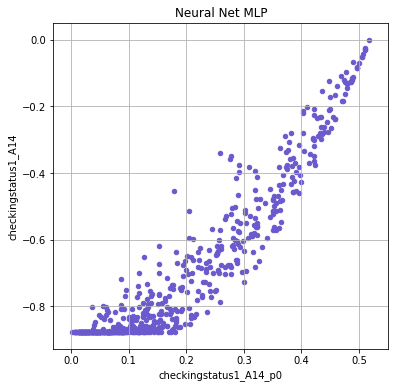

In [50]:
_ = Z.plot.scatter(x='amount5_p0',y='amount5',title='Neural Net MLP',
                    figsize=(6,6),grid=True,color='seagreen')
_ = Z.plot.scatter(x='checkingstatus1_A14_p0',y='checkingstatus1_A14',
                   title='Neural Net MLP',
                   figsize=(6,6),grid=True,color='slateblue')

In [55]:
# Export PD
dfout = pd.DataFrame({'y_est':y_est_mlp,'y':y_train.values})
dfout.to_csv('germancredit_mlp.csv',index=False)
display(pd.crosstab(pd.qcut(y_est_mlp,10),y_train).sort_index())

bad,0,1
row_0,,
"(0.00081, 0.0427]",33,25
"(0.0427, 0.0876]",38,21
"(0.0876, 0.152]",30,29
"(0.152, 0.22]",13,46
"(0.22, 0.283]",17,41
"(0.283, 0.375]",58,1
"(0.375, 0.436]",54,4
"(0.436, 0.485]",49,9
"(0.485, 0.513]",59,0
